# **Project 4 - Advanced Lane Finding**

## **1. Camera Calibration**

This section aims at calibrating the vehicle's camera in order to correct **radial and tangential distortion**, using a chessboard as a reference shape. To do so, 20 pictures of a chessboard have been taken from difference distances and angles.

Then we prepare **object points** which will be the (x, y, z) coordinates of the chessboard corners. We assume the chessboard is fixed on the (x, y) plane with depth z=0, such that object points are the same for each calibration image. Thus, the objp variable is just a replicated array of coordinates, and objpoints will be appended with an identical copy of it every time all chessboard corners are successfully detected  in a test image.

The **imgpoints** variable will be appended with the (x, y) pixel position of each of the corners in the image plane for each successful chessboard detection.

Then object_points and imgpoints are used to compute the **calibration matrix** using the opencv calibrateCamera function. Finally, the calibration matrix is used as the main parameter of our **undistort** function.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### **1.1 Setting up parameters for camera calibration**

In [2]:
# Building objpoints and imgpoints for camera calibration

# Number of inside corners on x axis
nx = 9
# Number of inside corners on y axis
ny = 6

# Initializing object points
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Initializing array of 3D points (real world images)
objpoints = []
# Initializing array of 2D points (2D images)
imgpoints = []

# Browsing calibration images
dir_name = './camera_cal/'
c = 0
for img_name in os.listdir(dir_name):
    # Initializing image
    img = mpimg.imread(dir_name + img_name)
    
    # Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Finding chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, adding object and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Drawing corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        # Incrementing counter
        c += 1
        
        # Plotting
        #plt.imshow(img)

#cv2.destroyAllWindows()
print('Corners successfully found in {} images.'.format(c))

Corners successfully found in 17 images.


In [3]:
# Defining function to calibrate camera and undistort images given objpoints and imgpoints
def cal_undistort(img, objpoints, imgpoints):
    import cv2

    # Converting to gray scale (assuming image read using cv2)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Calibrating camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # Undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
# Calibrating camera and saving distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Defining function to undistort images given objpoints and imgpoints
def undistort(img, objpoints, imgpoints, mtx, dist):
    import cv2

    # Converting to gray scale (assuming image read using cv2)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### **1.2 Testing camera calibration**

In [32]:
# Defining testing function
def test_undistort(img_name, input_folder, output_folder, objpoints, imgpoints, mtx, dist):
    
    import os
    import cv2
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # Getting name without extension
    img_name_split = img_name.split(os.extsep)
    img_name_noext = img_name_split[0]
    img_name_ext = img_name_split[1]
    
    # Reading image
    img = mpimg.imread(input_folder + img_name)
    
    # Running undistortion
    img_undist = undistort(img, objpoints, imgpoints, mtx, dist)
    
    # Saving output
    img_name_out = output_folder + img_name_noext + '_undistorted' + os.extsep + img_name_ext
    mpimg.imsave(img_name_out, img_undist)
    
    # Visualizing undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
    f.tight_layout()
    
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=15)
    
    ax2.imshow(img_undist)
    ax2.set_title('Undistorted Image', fontsize=15)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

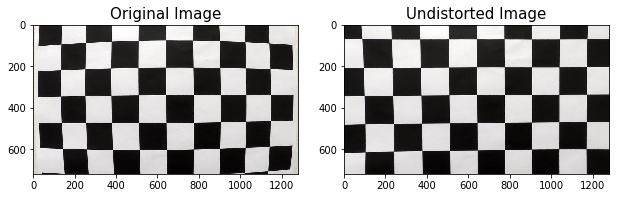

In [33]:
# Testing undistortion on chessboard image
test_undistort('calibration1.jpg', './camera_cal/', './output_images/', objpoints, imgpoints, mtx, dist)

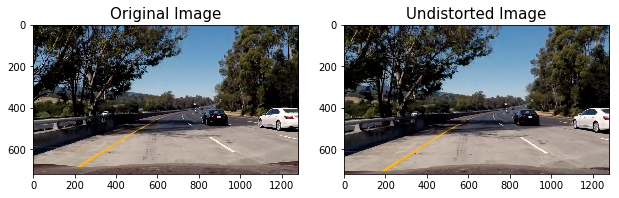

In [34]:
# Testing undistortion on chessboard image
test_undistort('test5.jpg', './test_images/', './output_images/', objpoints, imgpoints, mtx, dist)

## **2. Edge Detection**

This section builds the second step of our image processing pipeline: **detection of edges**.

First we convert images into **gray scale** and apply a **Gaussian blur** to reduce noise. 

Then we apply a **mask** to restrict edge detection to certain regions of interest in images: sides where lines are more likely to be found.

Then we try different **thresholding** techniques to filter regions with various amounts of change (gradient) in pixel intensity or direction, using the **Sobel** operator to compute the gradient.
- Gradient magnitude in x or y direction: how much pixel intensity changes with respect to x or y direction (*see threshold_abs function*)
- Gradient magnitude in both x and y directions: how much pixel intensity changes with respect to both x and y directions (*see threshold_mag function*)
- Gradient direction: in which direction pixel intensity changes (*see threshold_dir function*)

Then we try **color channel thresholding** (*see threshold_color function*): 
- Conversion into HLS or HSV color space
- Selection of different channels
- Application of thresholds

After multiple iterations, we opt for the following combination (*see threshold_all function*):
- Thresholding gradient magnitude in direction x, to focus on the detection of vertical lines
- Thresholding gradient magnitude in direction y, to focus on the detection of horizontal lines (important in harder_challenge video)
- Converting images to the HLS space and selecting the S channel.

The output is **binary images**: black and white images featuring edges.

### **2.1 Defining thresholding functions**

In [8]:
# Defining function for conversion to gray scale
def grayscale(img):
    import cv2
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Defining function for Gaussian blur
def gaussian_blur(img, gauss_ksize):
    import cv2
    return cv2.GaussianBlur(img, (gauss_ksize, gauss_ksize), 0)

# Vertices for region of interest
def calculate_vertices(img, left, top_y=0.6, top_x=0.05, med_x=0.5):
    
    # Getting image size
    imsshape = img.shape
    size_y = imsshape[0]
    size_x = imsshape[1]
        
    # Generating left mask
    if left:
        mask_left = np.array([[\
                               (size_x * top_x, size_y),\
                               (size_x * med_x, size_y * top_y),\
                               (size_x * 0.5, size_y * top_y),\
                               (size_x * 0.5, size_y)\
                              ]], dtype=np.int32)
        return mask_left
    
    # Generating right mask
    else:
        mask_right = np.array([[\
                                (size_x * 0.5, size_y),\
                                (size_x * 0.5, size_y * top_y),\
                                (size_x * (1 - med_x), size_y * top_y),\
                                (size_x * (1 - top_x), size_y)\
                               ]], dtype=np.int32)
        return mask_right

# Region of interest
def region_of_interest(img, vertices):
    # Defining blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining 3 channel or 1 channel color to fill mask with
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [9]:
# Defining gradient thresholding functions
import numpy as np

# Defining function for thresholding using gradient magnitude
def threshold_abs(img, sobel_kernel=3, orient='x', thresh=(0, 255)):   
    import cv2
    import numpy as np
    
    # Converting to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculating derivatives in both x and y directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculating absolute value of derivative, given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    else:
        abs_sobel = np.absolute(sobely)
    
    # Scaling to 8-bit (0 - 255) and converting to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Creating binary mask where gradient magnitude within threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

# Defining function for thresholding using gradient magnitude
def threshold_mag(img, sobel_kernel=3, thresh=(0, 255)):
    import cv2
    import numpy as np
    
    # Converting to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculating derivatives in both x and y directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculating total gradient magnitude 
    m = np.sqrt(sobelx**2 + sobely**2)
    
    # Scaling to 8-bit (0 - 255) and converting to type = np.uint8
    scaled_sobel = np.uint8(255 * m / np.max(m))
    
    # Creating binary mask where gradient magnitude within threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

# Defining function for thresholding using gradient direction
def threshold_dir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    import cv2
    import numpy as np
    
    # Converting to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculating derivatives in both x and y directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculating absolute value of x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculating direction of gradient 
    d = np.arctan2(abs_sobely, abs_sobelx)
    
    # Scaling to 8-bit (0 - 255) and converting to type = np.uint8
    #scaled_sobel = np.uint8(255 * d / np.max(d))
    
    # Creating binary mask where gradient magnitude within threshold
    binary_output = np.zeros_like(d)
    binary_output[(d >= thresh[0]) & (d <= thresh[1])] = 1
    
    return binary_output

In [10]:
# Defining function for color thresholding
def threshold_color(img, color_space='HLS', color_channel=[2], thresh=[(170, 255)]):
    # Converting to color space
    if color_space != 'RGB':
        if color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        elif color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    
    binary_output = np.zeros_like(img[:,:,0])
    for i in range(len(color_channel)):
        channel_c = img[:,:,color_channel[i]]
        binary_output[(channel_c > thresh[i][0]) & (channel_c <= thresh[i][1])] = 1
    
    return binary_output

In [11]:
# Defining function to combine thresholding techniques
def threshold_all(\
                  img, \
                  gauss_ksize=5, \
                  color_space='HLS', \
                  color_channel=[2], \
                  sobel_kernel=7, \
                  thresh_x=(30,150), \
                  thresh_y=(30,150), \
                  thresh_mag=(40, 255), \
                  thresh_dir=(0.7, 1.1), \
                  thresh_color=[(170,220)], \
                  apply_mask=True, \
                  top_y=0.6, top_x=0.08, med_x=0.45, \
                  vertices=[[[100,720],[640-200,420],[640,420],[400,720]], [[1280-400,720],[640,420],[640+200,420],[1280-100,720]]], \
                  plot_image=False
                  ):
    
    # Applying Gaussion blur to reduce noise
    img = gaussian_blur(img, gauss_ksize=gauss_ksize)
    
    # Applying color thresholding
    binary_color = threshold_color(img, color_space=color_space, color_channel=color_channel, thresh=thresh_color)
    
    # Applying gradient thresholding functions
    binary_grad_x = threshold_abs(img, sobel_kernel=sobel_kernel, orient='x', thresh=thresh_x)
    #binary_grad_y = threshold_abs(img, sobel_kernel=sobel_kernel, orient='y', thresh=thresh_y)
    #binary_mag = threshold_mag(img, sobel_kernel=sobel_kernel, thresh=thresh_mag)
    #binary_dir = threshold_dir(img, sobel_kernel=sobel_kernel, thresh=thresh_dir)
    
    # Combining gradient thresholding techniques
    #binary_grad = np.zeros_like(binary_grad_x)
    #binary_grad[((binary_grad_x == 1) & (binary_grad_y == 1)) | ((binary_mag == 1) & (binary_dir == 1))] = 1
    #binary_grad[((binary_grad_x == 1) | (binary_grad_y == 1)) & (binary_dir == 1) | ((binary_mag == 1) & (binary_dir == 1))] = 1
    #binary_grad[((binary_grad_x == 1) & (binary_grad_y == 1) & (binary_dir == 1))] = 1
    #binary_grad[(((binary_grad_x == 1) | (binary_grad_y == 1)) & (binary_dir == 1))] = 1
    #binary_grad[((binary_mag == 1) & (binary_dir == 1))] = 1
    #binary_grad[((binary_mag == 1) | (binary_dir == 1))] = 1
    #binary_grad[((binary_grad_x == 1) & (binary_grad_y == 1))] = 1
    binary_grad = binary_grad_x
    
    # Combining thresholding
    binary_combined = np.zeros_like(binary_grad)
    binary_combined[((binary_grad == 1) | (binary_color == 1))] = 1
        
    # Stacking thresholding in individual channels
    binary_stacked = np.dstack((np.zeros_like(binary_grad), binary_grad, binary_color))
    
    if apply_mask:
        if vertices == None:
            # Generating mask of interest - left and right sides
            vertices_l = calculate_vertices(binary_combined, True, top_y, top_x, med_x)
            vertices_r = calculate_vertices(binary_combined, False, top_y, top_x, med_x)
            vertices = np.concatenate((vertices_l, vertices_r))
        else:
            vertices = np.array(vertices, dtype=np.int32)
        #print('vertices = ', vertices)
        
        # Applying mask
        binary_combined = region_of_interest(binary_combined, vertices)
        
    # Plotting results
    if plot_image:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        f.tight_layout()

        ax1.imshow(img, cmap='gray')
        ax1.set_title('Original Image', fontsize=15)

        ax2.imshow(binary_combined, cmap='gray')
        ax2.set_title('Thresholded Image', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return binary_combined

### **2.2 Testing different thresholding techniques**

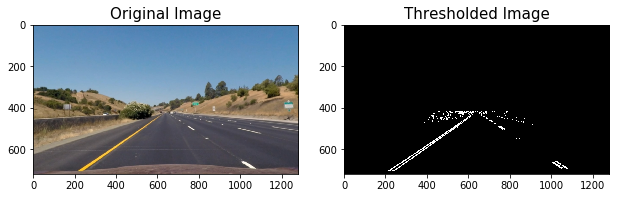

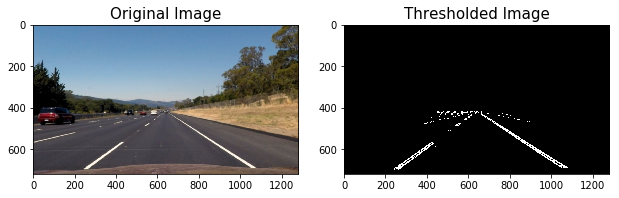

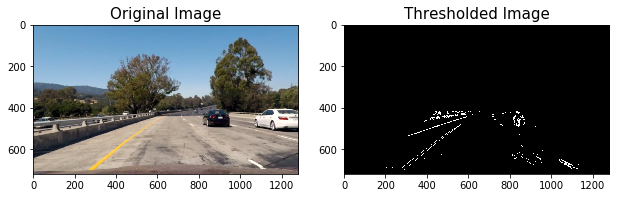

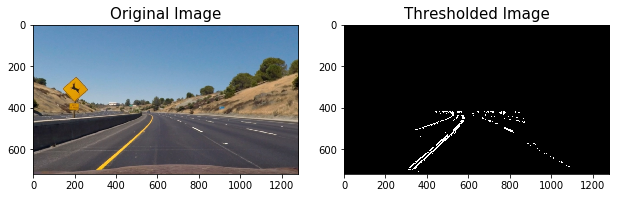

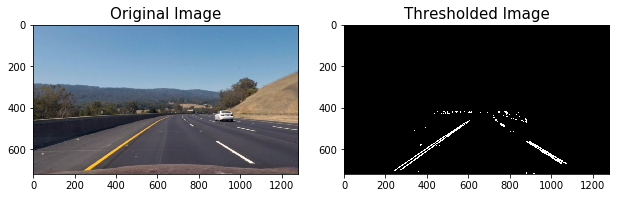

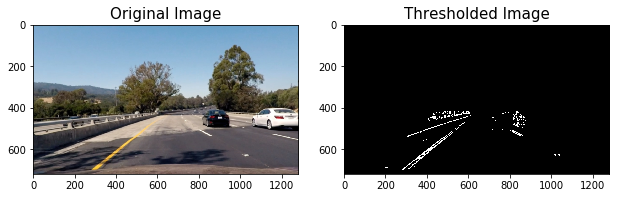

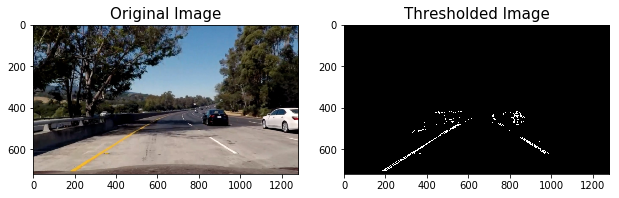

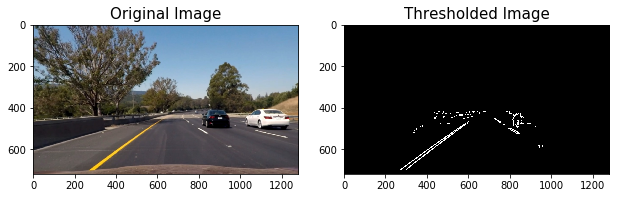

In [12]:
# Testing thresholding
dir_name = './test_images/'
for img_name in os.listdir(dir_name):
    # Reading test image
    img_test = mpimg.imread(dir_name + img_name)
    
    # Correcting distortion
    img_undist = undistort(img_test, objpoints, imgpoints, mtx, dist)
    
    # Thresholding
    #img_thresh = threshold_all(img_undist, thresh_color=(200, 255), apply_mask=True, plot_image=True)
    #img_thresh = threshold_all(img_undist, color_space='RGB', color_channel=[0,1,2], thresh_color=[(240,255),(240,255),(240,255)], apply_mask=True, plot_image=True)
    img_thresh = threshold_all(img_undist, plot_image=True)

## **3. Image warping**

This section aims at converting images from front-facing view into **bird's eye** view.

The first step consists in using a **reference image** with **straight lines**, that we assume parallel. Then we choose 4 points forming a **trapeze** on that perspective view, to be converted into a **rectangle** on a bird's eye view.

In order to identify those 4 points, we reused our pipeline from project 1 to detect **straight lines** on the reference image. Then two values of y, one at the bottom of the image, one roughly in the middle of the image, to derive x values from those straight lines.

Once we have those 4 **source points**, we assign them 4 corresponding **destination points**, defined manually. Then we can compute the perspective transform matrix and its inverse using the opencv getPerspectiveTransform function.

We finally build a warping / unwarping function (*see warp function below*) to convert front-facing camera images into bird's eye view.

### **3.1 Finding straight lines on reference image**

In [13]:
# Definining functions to find straight lines (from Project 1)
# Will be used to define warping parameters
import math

# Canny edge detections
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# To draw lines on image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2, slope_thrsh=0.2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)                
                
# To find Hough lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, slope_thrsh=0.2):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Filtering lines with sufficient slope
    lines = filter_lines(lines)
    
    # Initializing black image with same size as original
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    return line_img, lines

# To merge images
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# To filter lines with minimum slope
def filter_lines(lines, slope_thrsh=0.2):
    slopes_above = np.array([abs((line[0][3] - line[0][1]) / (line[0][2] - line[0][0])) >= slope_thrsh for line in lines])
    lines_filtered = lines[slopes_above]
    return lines_filtered

# Defining linear function to extrapolate lines (least-square polynomial fit)
def extrap_linear(img, lines, step_sign, degree=1, top_y=0.6, color=[255, 0, 0], thickness=2):
    
    # Extracting x-coordinates
    xs1 = np.array([line[0][0] for line in lines])
    xs2 = np.array([line[0][2] for line in lines])
    xs = np.concatenate((xs1, xs2))
    
    # Extracting y-coordinates
    ys1 = np.array([line[0][1] for line in lines])
    ys2 = np.array([line[0][3] for line in lines])
    ys = np.concatenate((ys1, ys2))
    
    # Applying polynomial fitting
    coeffs = np.polyfit(xs, ys, degree)
    
    # Defining linear function (assuming degree=1)
    p = np.poly1d(coeffs)
    
    # Initializing black image with same size as original
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Drawing extrapolated lines (with 3 points)
    # Fixing y as bottom of image (img.shape[0]) and getting x
    y0 = img.shape[0]
    x0 = int((y0 - coeffs[1]) / coeffs[0])
    
    # Getting median x and deriving y
    x1 = np.median(xs)
    y1 = int(p(x1))
    
    # Fixing y as top of region of interest (using top_y argument) and getting x
    y2 = int(top_y * img.shape[0])
    x2 = int((y2 - coeffs[1]) / coeffs[0])
    
    # Concatenating points
    pts = np.array([[x0,y0], [x1,y1], [x2,y2]], np.int32)
    
    # Drawing 3-points line
    cv2.polylines(line_img, [pts], True, color, 8)
    
    #return line_img, pts
    return line_img, coeffs

In [14]:
# Defining pipeline to find straight lines
def find_straight_lines(\
                        img, \
                        gauss_kernel=5, \
                        canny_low_thrsh=50, canny_high_thrsh=150, \
                        top_y=0.6, top_x=0.1, med_x=0.5, \
                        hough_rho=2, hough_theta=np.pi/180, hough_thrsh=15, hough_min_len=20, hough_max_gap=20, \
                        draw_lines=False \
                        ):
    
    # Applying gray filter
    img_gray = grayscale(img)
    
    # Applying Gaussian smoothing
    img_gauss = gaussian_blur(img_gray, gauss_kernel)
    
    # Applying Canny
    img_canny = canny(img_gauss, canny_low_thrsh, canny_high_thrsh)
    
    # Applying mask of interest - left side
    img_mask_left = region_of_interest(img_canny, calculate_vertices(img_canny, True, top_y, top_x, med_x))
    
    # Applying mask of interest - right side
    img_mask_right = region_of_interest(img_canny, calculate_vertices(img_canny, False, top_y, top_x, med_x))
    
    # Applying Hough transform - left side
    img_hough_left, lines_left = hough_lines(img_mask_left, hough_rho, hough_theta, hough_thrsh, hough_min_len, hough_max_gap)
    
    # Applying Hough transform - right side
    img_hough_right, lines_right = hough_lines(img_mask_right, hough_rho, hough_theta, hough_thrsh, hough_min_len, hough_max_gap)
    
    # Extrapolating lines - Left side
    img_extra_left, coeffs_left = extrap_linear(img_hough_left, lines_left, 1)
    
    # Extrapolating lines - Right side
    img_extra_right, coeffs_right = extrap_linear(img_hough_right, lines_right, -1)
    
    # Drawing lines on initial image\
    if draw_lines:
        img_output = weighted_img(img_extra_left, img)
        img_output = weighted_img(img_extra_right, img_output)
    
    # Returning output
    return img, coeffs_left, coeffs_right

In [15]:
# Reading reference image (with straight lanes)
img_ref = mpimg.imread('./test_images/straight_lines1.jpg')

# Getting image size
img_size = (img_ref.shape[1], img_ref.shape[0])

# Correcting distortion
img_undist = undistort(img_ref, objpoints, imgpoints, mtx, dist)

# Finding straight lanes on image
img_undist, coeffs_left, coeffs_right = find_straight_lines(img_undist, top_y=0.6, top_x=0.05, med_x=0.5, draw_lines=False)

### **3.2 Finding source points on reference image as warping parameters**

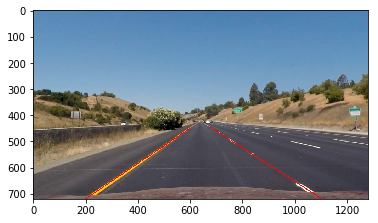

In [16]:
# Getting 4 source points on lines to draw a trapeze
# Bottom left point (fixing y and inferring x)
y = img_size[1]
x = int((y - coeffs_left[1]) / coeffs_left[0])
src_left_bottom = [x,y]
# Top left point (fixing y and inferring x)
y = 445
x = int((y - coeffs_left[1]) / coeffs_left[0])
src_left_top = [x,y]
# Top right point (fixing y and inferring x)
y = 445
x = int((y - coeffs_right[1]) / coeffs_right[0])
src_right_top = [x,y]
# Bottom right point (fixing y and inferring x)
y = img_size[1]
x = int((y - coeffs_right[1]) / coeffs_right[0])
src_right_bottom = [x,y]

# Building source points (trapeze)
src = np.float32([src_left_bottom, src_left_top, src_right_top, src_right_bottom])

# Drawing source points (trapeze) on image
img_lines = np.copy(img_undist)
img_lines = cv2.polylines(img_lines, [src.astype(int)], True, [255, 0, 0], 2)

# Plotting result
plt.imshow(img_lines)

### **3.3 Defining warping parameters**

In [17]:
# Defining destination points to transform trapeze into rectangle (front-facing camera into bird's eye view)
dst_left_bottom = [320, 720] 
dst_left_top = [320, 0]
dst_right_top = [960, 0]
dst_right_bottom = [960, 720]
dst = np.float32([dst_left_bottom, dst_left_top, dst_right_top, dst_right_bottom])

# Getting perspective transform and inverse perspective transform
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

In [18]:
# Defining function to warp images
def warp(img, M, src, dst, plot_image=False, draw_lines=False):
    # Getting image size
    img_size = (img.shape[1], img.shape[0])
    
    # Generating warped image (bird's eye view)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    
    # Plotting results
    if plot_image:
        # Drawing source points on image
        img_lines = np.copy(img)
        if draw_lines:
            img_lines = cv2.polylines(img_lines, [src.astype(int)], True, [255, 0, 0], 2)
        
        # Drawing destination points on image
        warped_lines = np.copy(warped)
        if draw_lines:
            warped_lines = cv2.polylines(warped_lines, [dst.astype(int)], True, [255, 0, 0], 2)

        # Plotting result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        f.tight_layout()

        ax1.imshow(img_lines, cmap='gray')
        ax1.set_title('Original Image', fontsize=15)

        ax2.imshow(warped_lines, cmap='gray')
        ax2.set_title('Warped Image', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped

### **3.4 Testing warping**

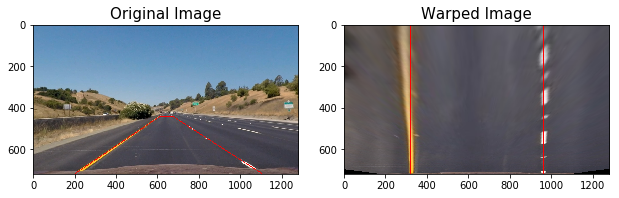

In [19]:
# Generating warped image (bird's eye from front-facing camera view)
img_warped = warp(img_undist, M, src, dst, plot_image=True, draw_lines=True)

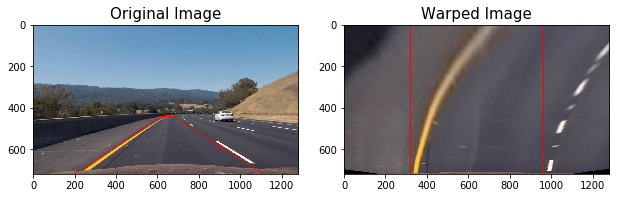

In [20]:
# Testing on curved lanes

# Reading image
img_test = mpimg.imread('./test_images/test3.jpg')

# Correcting distortion
img_undist = undistort(img_test, objpoints, imgpoints, mtx, dist)

# Generating warped image (bird's eye from front-facing camera view)
img_warped = warp(img_undist, M, src, dst, plot_image=True, draw_lines=True)

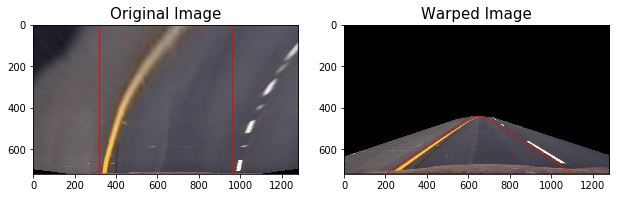

In [21]:
# Testing unwarping

# Generating unwarped image (front-facing camera from bird's eye view)
img_unwarped = warp(img_warped, M_inv, dst, src, plot_image=True, draw_lines=True)

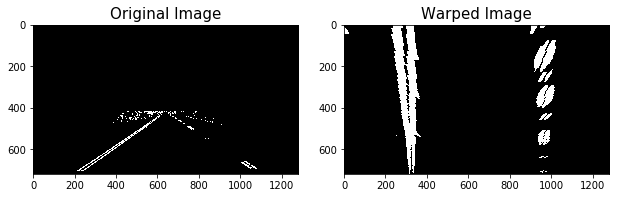

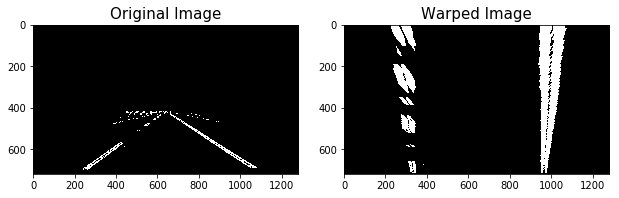

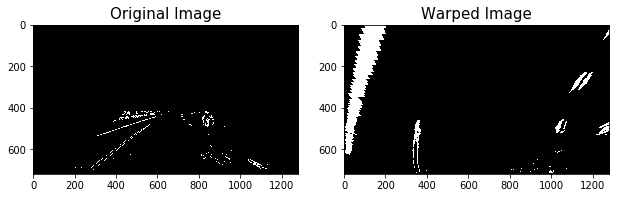

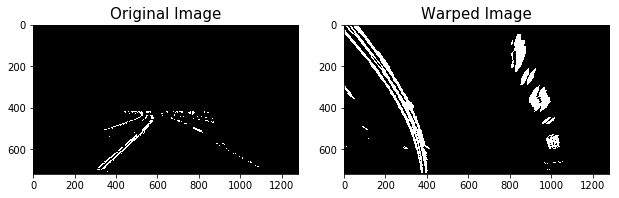

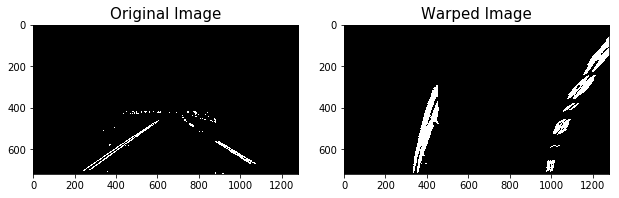

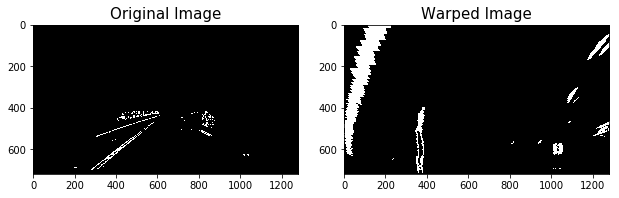

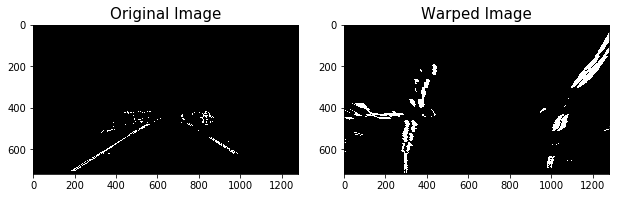

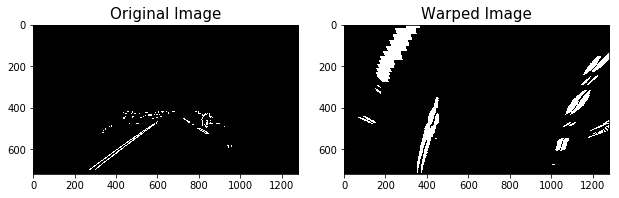

In [22]:
# Testing on thresholded images
dir_name = './test_images/'
for img_name in os.listdir(dir_name):
    # Reading test image
    img_test = mpimg.imread(dir_name + img_name)
    
    # Correcting distortion
    img_undist = undistort(img_test, objpoints, imgpoints, mtx, dist)
    
    # Thresholding
    img_thresh = threshold_all(img_undist, plot_image=False)
    
    # Generating warped image (bird's eye from front-facing camera view)
    img_warped = warp(img_thresh, M, src, dst, plot_image=True, draw_lines=False)

## **4. Finding and Drawing Lanes**

This section is at the core of our pipeline. The find_lanes function is designed to work on **warped binary images** (i.e. bird's eye view black and white images). It does the following:

- We extract non-Zero pixels from the binary image.

- When no line has been detected in the prior image:
    - We build a **histogram** of pixels.
    - Then we identify two **peaks** in the histogram, one for each side.
    - Then for each side, starting from peaks at the bottom of the image, we slide nine 100 pixel-wide **windows** all the way to the top:
        - For each window, we get **non-zero** pixels.
        - We collect **indices** corresponding to those pixels into a list.
        - We **recenter** the window to the mean position of non-zero pixels for the next iteration.

- When lines have been detected in the prior image: for each side, we identify **indices** of non-zero pixels within a (-55,55) pixel range around the previous fit.

- Then for each side, we extract pixel positions corresponding to indices and fit a **2nd order polynomial** to them using the Numpy polyfit function.

- Then we compute the **radius** of curvature for each side and the **lane width** as the distance between lines at the bottom of the image.

- We finally perform the following **sanity checks**:
    - Radius curvature no different from previous image by more than 30%.
    - Lane width between 500 and 800 pixels.

- If sanity checks are verified, lines are considered **detected** and appended to the list of 15 **most recent fits** for later use (*see information about Line class below*).

For this entire process, we can choose to perform calculations in pixel units or in real-world meters (**conversion**).

To improve performances and store history of lane findings, each successfully detected left and right lines are assigned to the **Line class**, along with the following properties:
- **Number of images** processed so far
- Number of successfully found lines to keep in **buffer**
- Line **detected**
- **Current fit** (i.e. polynomial coefficients)
- N most **recent fits** (polynomial coefficients)
- **Best fit**, i.e. average of n most recent fits
- Line curvature **radius**
- Vehicle **position** (identical in both left and right line)

Then the draw_lanes function defaults to the **best fit** (averaged n most recent polynomial coefficients) to **draw lines and lanes** on images.

### **4.1 Defining a class to store parameters of lanes**

In [23]:
# Defining class to store line detection parameters
class Line():
    def __init__(self):
        # Number of images processed so far
        self.count = 0
        
        # Number of images (with lanes successfully found) to keep in buffer
        self.buffer = 15
        
        # Line detected in last iteration?
        self.detected = False
        
        # Polynomial coefficients for most recent fit
        self.current_fit = np.empty((0,0))
        
        # Polynomial coefficients for n most recent fits
        self.n_fits = []
        
        # Polynomial coefficients averaged over last n iterations
        self.best_fit = None
        
        # Radius of curvature of the line in some units
        self.radius = None
        
        # Position of vehicle
        self.position = None

### **4.2 Defining function to find lanes**

In [24]:
# Defining function to find lanes
def find_lanes(img, convert_unit=True, plot_image=False):
    
    # Initializing variables
    left_found = False
    right_found = False
    check_left_radius = False
    check_right_radius = False
    check_distance = False
    left_fit = [0,0,0]
    right_fit = [0,0,0]
    
    # Defining conversions in x and y from pixels space to meters
    if convert_unit:
        # Meters per pixel in x dimension
        xm_per_pix = 3.7/700
        # Meters per pixel in y dimension
        ym_per_pix = 30/720
    else:
        # Meters per pixel in x dimension
        xm_per_pix = 1
        # Meters per pixel in y dimension
        ym_per_pix = 1
    
    # Creating output image to draw on
    if plot_image:
        out_img = np.dstack((img, img, img))*255
    
    # Identifying x and y positions of all nonzero pixels in image
    nonzero = img.nonzero()
    #print('nonzero = ', nonzero)
    nonzeroy = np.array(nonzero[0])
    #print('nonzeroy = ', nonzeroy)
    nonzerox = np.array(nonzero[1])
    #print('nonzerox = ', nonzerox)
    
    # If lines not detected in previous image
    if left_line.detected == False or right_line.detected == False:
        
        # Getting histogram of bottom half of image
        histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
        
        # Finding peaks on left and right sides of histogram
        midpoint = np.int(histogram.shape[0]/2)
        #leftx_base = np.argmax(histogram[:midpoint])
        #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        offset = 80
        leftx_base = np.argmax(histogram[offset:midpoint])
        rightx_base = np.argmax(histogram[midpoint:img.shape[1]-offset]) + midpoint
        
        # Choosing number of sliding windows
        nwindows = 9
        
        # Setting window height
        window_height = np.int(img.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Setting width of windows +/- margin
        margin = 100
        
        # Setting minimum number of pixels found to recenter window
        minpix = 50
        
        # Creating empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Stepping through windows one by one
        for window in range(nwindows):
            # Identifying window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Drawing windows on visualization image
            if plot_image:
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identifying nonzero pixels in x and y within window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Appending indices to lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If pixels found > minpix, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Concatenate arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        
        # Setting width of windows +/- margin
        margin = 55
        
        # Getting coefficients from previous image
        left_fit = left_line.current_fit
        #print('left_fit = ', left_fit)
        right_fit = right_line.current_fit
        #print('right_fit = ', right_fit)
        
         # Identifying nonzero pixels in x and y within window
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    if len(leftx) > 0 and len(lefty) > 0 and len(rightx) > 0 and len(righty) > 0:
        # Fitting second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    
        # Calculating curvature radius (using middle of image)
        y_eval = (img.shape[0]-1)/2
        if convert_unit:
            # Fitting new polynomials to x,y in world space
            ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
        else:
            left_fit_cr = left_fit
            right_fit_cr = right_fit

        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

        # Performing sanity check on curvatures
        if left_line.radius == None:
            check_left_radius = True
        else:
            if abs(left_curverad / left_line.radius - 1) < 0.7:
                check_left_radius = True

        if right_line.radius == None:
            check_right_radius = True
        else:
            if abs(right_curverad / right_line.radius - 1) < 0.7:
                check_right_radius = True


        # Calculating vehicle (camera) position (using bottom of image)
        y_eval = img.shape[0]-1
        left_x = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]) * xm_per_pix
        right_x = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]) * xm_per_pix
        position = img.shape[1] * xm_per_pix / 2 - (left_x + right_x) / 2


        # Calculating lane width (using bottom of image)
        lane_width = abs(left_x - right_x)
        #print('lane_width = ', lane_width)

        # Performing sanity check on lane width
        if check_left_radius and check_right_radius:
            lane_width_min = 500.0 * xm_per_pix
            lane_width_max = 900.0 * xm_per_pix
            if lane_width >= lane_width_min and lane_width <= lane_width_max:
                check_lane_width = True
                left_found = True
                right_found = True
                
        
        # Updating lines properties
        left_line.count += 1
        left_line.detected = left_found
        left_line.current_fit = left_fit #np.mean((left_fit, right_fit), axis=0)
        if left_found:
            # Keeping only n-1 last good fits
            left_line.n_fits = left_line.n_fits[-(left_line.buffer-1):]
            # Adding current fit
            left_line.n_fits.append(left_fit)
        # Averaging n last good fits
        left_line.best_fit = np.mean(left_line.n_fits, axis=0)
        left_line.radius = left_curverad
        left_line.position = position

        right_line.count += 1
        right_line.detected = right_found
        right_line.current_fit = right_fit #np.mean((left_fit, right_fit), axis=0)
        if right_found:
            # Keeping only n-1 last good fits
            right_line.n_fits = right_line.n_fits[-(right_line.buffer-1):]
            # Adding current fit
            right_line.n_fits.append(right_fit)
        # Averaging n last good fits
        right_line.best_fit = np.mean(right_line.n_fits, axis=0)
        right_line.radius = right_curverad
        right_line.position = position
    
    
    # Plotting results
    if plot_image:
        # Generating x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Coloring left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        if check_left_radius and check_right_radius and check_lane_width:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
            f.tight_layout()

            ax1.imshow(out_img)
            ax1.plot(left_fitx.astype(int), ploty, color='yellow')
            ax1.plot(right_fitx.astype(int), ploty, color='yellow')
            ax1.set_xlim(0, 1280)
            ax1.set_ylim(720, 0)

            ax2.plot(histogram)

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            
        else:
            # Creating image to show selection window
            window_img = np.zeros_like(out_img)

            # Generating polygon to illustrate search window area
            # And recasting x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Drawing lane onto warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

            plt.figure(figsize=(8,3))
            plt.imshow(result)
            plt.plot(left_fitx.astype(int), ploty, color='yellow')
            plt.plot(right_fitx.astype(int), ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
    
    return left_line, right_line

### **4.3 Testing lane finding function**

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


left line detected =  True
right line detected =  True
left current fit =  [  5.32757999e-04  -6.60536257e-01   5.50142126e+02]
right current fit =  [  4.71898763e-04  -7.72432262e-01   1.30786233e+03]
left n fits =  [array([  5.32757999e-04,  -6.60536257e-01,   5.50142126e+02])]
right n fits =  [array([  4.71898763e-04,  -7.72432262e-01,   1.30786233e+03])]
left best fit =  [  5.32757999e-04  -6.60536257e-01   5.50142126e+02]
right best fit =  [  4.71898763e-04  -7.72432262e-01   1.30786233e+03]
left radius =  308.830762568
right radius =  349.589851494
vehicle position =  -0.177252352581


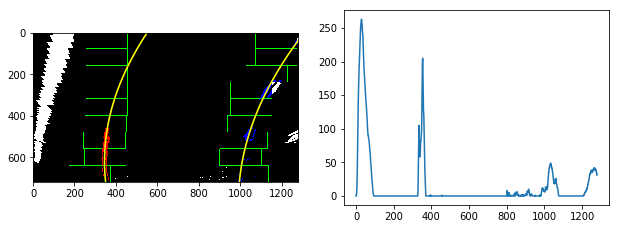

In [25]:
# Testing with single image

# Reading test image
img_test = mpimg.imread('./test_images/test1.jpg')

# Correcting distortion
img_undist = undistort(img_test, objpoints, imgpoints, mtx, dist)

# Thresholding
img_thresh = threshold_all(img_undist, apply_mask=True, plot_image=False)

# Generating warped image (bird's eye from front-facing camera view)
img_warped = warp(img_thresh, M, src, dst, plot_image=False, draw_lines=False)

# Finding lanes
left_line = Line()
right_line = Line()
left_line, right_line = find_lanes(img_warped, convert_unit=True, plot_image=True)

# Printing parameters
print('left line detected = ', left_line.detected)
print('right line detected = ', right_line.detected)
print('left current fit = ', left_line.current_fit)
print('right current fit = ', right_line.current_fit)
print('left n fits = ', left_line.n_fits)
print('right n fits = ', right_line.n_fits)
print('left best fit = ', left_line.best_fit)
print('right best fit = ', right_line.best_fit)
print('left radius = ', left_line.radius)
print('right radius = ', right_line.radius)
print('vehicle position = ', left_line.position)

left line detected =  False
right line detected =  False
left current fit =  [  1.57228828e-04  -3.83364730e-01   5.40845336e+02]
right current fit =  [  3.96263184e-04  -7.79989921e-01   1.33682222e+03]
left n fits =  [array([  5.32757999e-04,  -6.60536257e-01,   5.50142126e+02])]
right n fits =  [array([  4.71898763e-04,  -7.72432262e-01,   1.30786233e+03])]
left best fit =  [  5.32757999e-04  -6.60536257e-01   5.50142126e+02]
right best fit =  [  4.71898763e-04  -7.72432262e-01   1.30786233e+03]
left radius =  1046.35066005
right radius =  416.89296629
vehicle position =  -0.125137565975


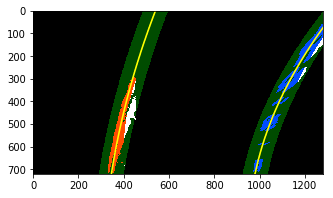

In [26]:
# Reading test image
img_test = mpimg.imread('./test_images/test3.jpg')

# Correcting distortion
img_undist = undistort(img_test, objpoints, imgpoints, mtx, dist)

# Thresholding
img_thresh = threshold_all(img_undist, plot_image=False)

# Generating warped image (bird's eye from front-facing camera view)
img_warped = warp(img_thresh, M, src, dst, plot_image=False, draw_lines=False)

# Finding lanes
left_line, right_line = find_lanes(img_warped, convert_unit=True, plot_image=True)

# Printing parameters
print('left line detected = ', left_line.detected)
print('right line detected = ', right_line.detected)
print('left current fit = ', left_line.current_fit)
print('right current fit = ', right_line.current_fit)
print('left n fits = ', left_line.n_fits)
print('right n fits = ', right_line.n_fits)
print('left best fit = ', left_line.best_fit)
print('right best fit = ', right_line.best_fit)
print('left radius = ', left_line.radius)
print('right radius = ', right_line.radius)
print('vehicle position = ', left_line.position)

### **4.4 Defining function to draw lanes on images**

In [27]:
# Defining function to draw lanes on image
def draw_lanes(img, img_warped, left_line, right_line, M_inv, current_fit=False, plot_image=False):
    # Getting polynomial coefficients
    if current_fit:
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
    else:
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
    
    
    # Generating x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    #print('ploty = ', ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #print('left_fitx = ', left_fitx)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print('right_fitx = ', right_fitx)
    
    # Creating image to draw lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recasting x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Drawing lanes onto warped blank image (in green)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Drawing left and right lines onto warped blank image (in red and blue)
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0,0))
    cv2.fillPoly(color_warp, np.int_([pts_right]), (0,0,255))
    
    # Warping blank back to original image space using inverse perspective matrix (M_inv)
    img_unwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    
    # Combining lines and lane with original image
    result = cv2.addWeighted(img, 1, img_unwarp, 0.3, 0)
    
    # Adding text on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Adding curvature radii
    text = "Left Curvature Radius: {}m".format(int(left_line.radius))
    cv2.putText(result, text, (20,200), font, 1.1, (255,255,255), 2)

    text = "Right Curvature Radius: {}m".format(int(right_line.radius))
    cv2.putText(result, text, (700,200), font, 1.1,(255,255,255), 2)
    
    # Adding position of car
    if left_line.position < 0:
        text = "Vehicle is {:.2f}m left of center".format(-left_line.position)
    else:
        text = "Vehicle is {:.2f}m right of center".format(left_line.position)
    cv2.putText(result, text, (380,100), font, 1.1, (255,255,255), 2)
    
    # Plotting results
    if plot_image:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        f.tight_layout()

        ax1.imshow(img_warped, cmap='gray')
        ax1.set_title('Warped Image', fontsize=15)

        ax2.imshow(result, cmap='gray')
        ax2.set_title('Image With Lane', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return result

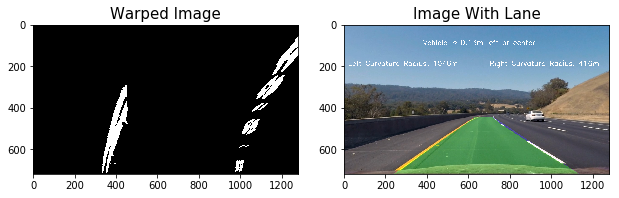

In [28]:
# Testing draw_lanes function:
img_lane = draw_lanes(img_undist, img_warped, left_line, right_line, M_inv, current_fit=True, plot_image=True)

## **5. Image processing pipeline**

This section gathers all previously built functions into the following pipeline:
- Correcting camera distortion
- Thresholding (gradient and color selection)
- Warping
- Finding lanes
- Drawing lanes on images (averaging n last fits)

Then we apply this pipeline to test images and test videos.

### **5.1 Defining pipeline**

In [29]:
# Defining pipeline
def process_image(img, current_fit=False, plot_image_lanes=False, plot_image=False):
    # Correcting distortion
    img_undist = undistort(img, objpoints, imgpoints, mtx, dist)
    
    # Thresholding
    img_thresh = threshold_all(img_undist)
    
    # Generating warped image (bird's eye from front-facing camera view)
    img_warped = warp(img_thresh, M, src, dst)
    
    # Finding lanes
    global left_line
    global right_line
    left_line, right_line = find_lanes(img_warped, convert_unit=True)
    
    # Drawing lanes
    img_lane = draw_lanes(img_undist, img_warped, left_line, right_line, M_inv, current_fit=current_fit, plot_image=plot_image)
    
    return img_lane

### **5.2 Running pipeline on test images**

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


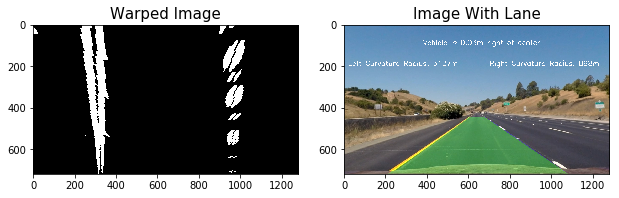

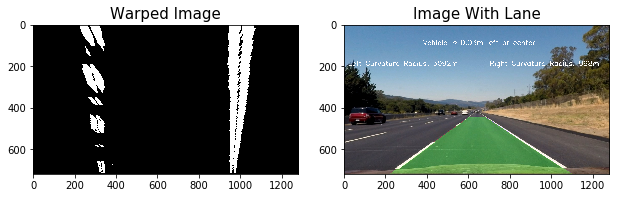

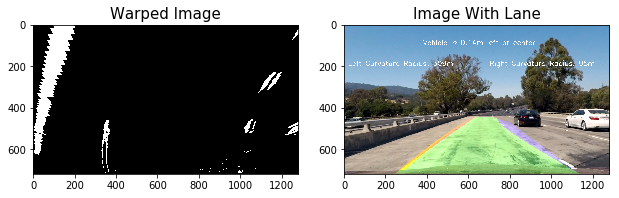

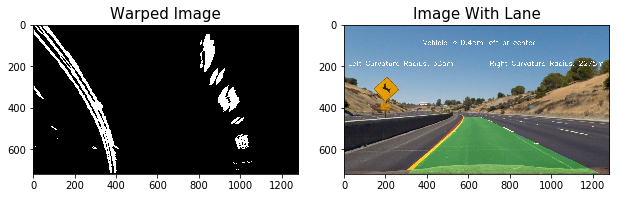

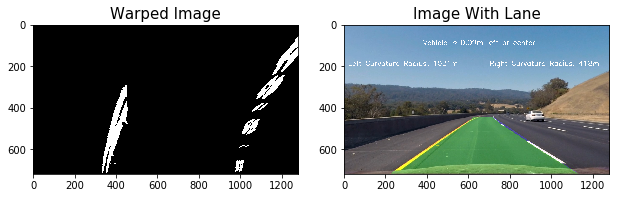

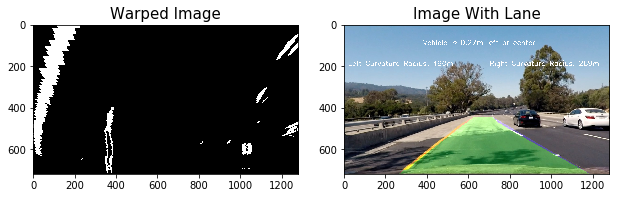

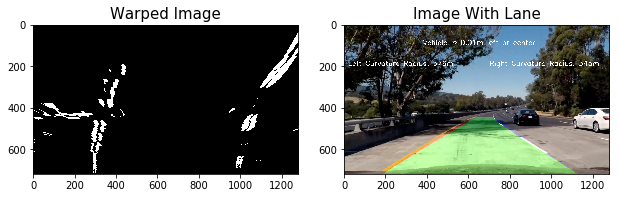

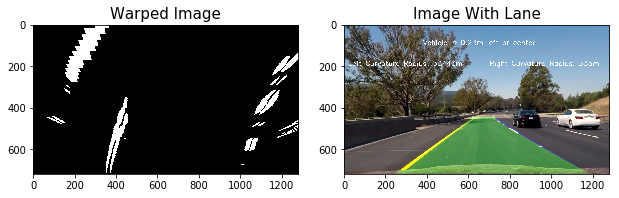

In [30]:
# Testing on images
dir_name = './test_images/'
output_folder = './output_images/'

## Initializing lines
left_line = Line()
right_line = Line()

# Browsing images
for img_name in os.listdir(dir_name):
    # Getting name without extension
    img_name_split = img_name.split(os.extsep)
    img_name_noext = img_name_split[0]
    img_name_ext = img_name_split[1]
    
    # Reading test image
    img_test = mpimg.imread(dir_name + img_name)
    
    # Processing image
    img_lane = process_image(img_test, current_fit=True, plot_image_lanes=False, plot_image=True)
    
    # Saving output
    img_name_out = output_folder + img_name_noext + '_lanes' + os.extsep + img_name_ext
    mpimg.imsave(img_name_out, img_lane)

### **5.3 Running pipeline on videos** 

In [31]:
# Importing libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Initializing videa names
input_names = ['project_video.mp4', 'challenge_video.mp4', 'harder_challenge_video.mp4']
#input_names = ['project_video.mp4']
#input_names = ['challenge_video.mp4']
#input_names = ['harder_challenge_video.mp4']

for input_name in input_names:
    # Splitting input name
    input_name_split = input_name.split(os.extsep)
    input_name_noext = input_name_split[0]
    input_name_ext = input_name_split[1]

    # Setting output name
    output_name = input_name_noext + '_lanes' + os.extsep + input_name_ext

    # Initializing video
    input_clip = VideoFileClip(input_name)

    # Initializing lines
    left_lane = Line()
    right_lane = Line()

    # Processing video
    output_clip = input_clip.fl_image(process_image)
    %time output_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:56<00:00,  4.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

Wall time: 4min 58s
[MoviePy] >>>> Building video challenge_video_lanes.mp4
[MoviePy] Writing video challenge_video_lanes.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:48<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_lanes.mp4 

Wall time: 1min 50s
[MoviePy] >>>> Building video harder_challenge_video_lanes.mp4
[MoviePy] Writing video harder_challenge_video_lanes.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [04:49<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_lanes.mp4 

Wall time: 4min 53s
